 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8889/notebooks/keras/keras_cbrain.ipynb#Visualize-the-task-of-the-network" data-toc-modified-id="Visualize-the-task-of-the-network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualize the task of the network</a></span></li><li><span><a href="http://localhost:8889/notebooks/keras/keras_cbrain.ipynb#Some-tests-with-Keras" data-toc-modified-id="Some-tests-with-Keras-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Some tests with Keras</a></span><ul class="toc-item"><li><span><a href="http://localhost:8889/notebooks/keras/keras_cbrain.ipynb#Fully-connected-neural-network" data-toc-modified-id="Fully-connected-neural-network-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fully connected neural network</a></span></li><li><span><a href="http://localhost:8889/notebooks/keras/keras_cbrain.ipynb#Convolutional-neural-network" data-toc-modified-id="Convolutional-neural-network-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Convolutional neural network</a></span></li><li><span><a href="http://localhost:8889/notebooks/keras/keras_cbrain.ipynb#A-better-network?" data-toc-modified-id="A-better-network?-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>A better network?</a></span></li></ul></li><li><span><a href="http://localhost:8889/notebooks/keras/keras_cbrain.ipynb#Visualize-predictions" data-toc-modified-id="Visualize-predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualize predictions</a></span></li></ul></div>

# A Keras implementation of CBRAIN

The goal of this exercise is to write the CBRAIN algorithms from scratch so I really understand everything that is going on. This will also serve as a good comparison for the Tensorflow algorithm. 

I will also use this notebook to explore the data a little more: What are the inputs, what are the required outputs and where does the neural net have problems?

This notebook uses functions and classes which are defined in the following helper scripts:
- `utils.py`: General utility functions including visualization
- `data_generator.py`: Definition of DataGenerator class
- `models.py`: Definition of the Keras neural nets
- `losses.py`: Definition of the custom loss functions
- `run_experiments.py`: Wrapper script to run experiments outside of notebook

In [68]:
# Imports
from importlib import reload
import utils; reload(utils);
from utils import *
import data_generator; reload(data_generator);
from data_generator import *
import models; reload(models);
from models import *
%matplotlib inline
from scipy.stats import binned_statistic

In [2]:
# Limit Tensorflow GPU memory usage
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2   # GPU RAM usage fraction of 4GB
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
# Define data paths
sample_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sample/'   # 100,000 samples
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/' # Full dataset

## Visualize the task of the network

Let's start by getting an intuition of the task at hand. For this let's just plot some inputs (features) and outputs (targets) of the algorithm.

In [4]:
# Define a dictionary containing the feature and target variables
# and the number of dimensions
feature_vars = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'OMEGA': 2,           # [z, sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'QRL': 2,             # Long wave heating rate [z, sample]
    'QRS': 2,             # Short wave heating rate [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
    'LAT': 1,             # Latitude [sample]
})
target_vars = OrderedDict({
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
})

In [60]:
# Open the training set
train_out = nc.Dataset(data_dir + 'SPCAM_outputs_train.nc')

Let's get a feeling for the variability of the output

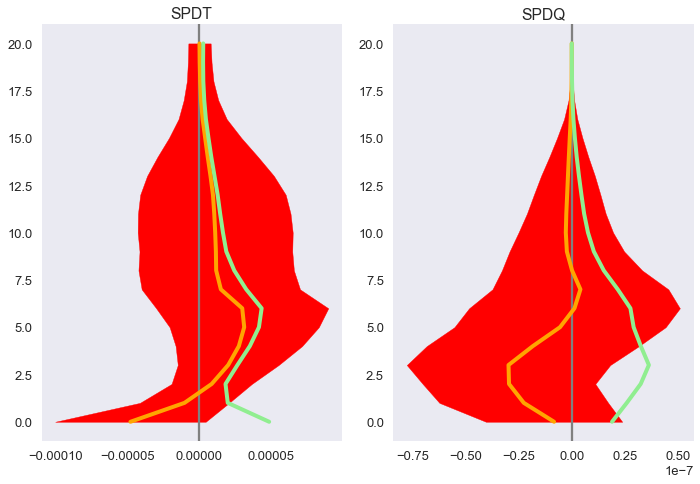

In [61]:
z = np.arange(train_out.variables['SPDT'][:].shape[0]-1, -1, -1)
fig, axes = plt.subplots(1, 2)
for i, var in enumerate([train_out.variables['SPDT'], train_out.variables['SPDQ']]):
    mean = np.mean(var[:], axis=1)
    mean_abs = np.mean(np.abs(var[:]), axis=1)
    mn = np.min(var[:], axis=1); mx = np.max(var[:], axis=1)
    std = np.std(var[:], axis=1, ddof=1)
    axes[i].set_title(var.name)
    axes[i].plot(mean, z, c='orange', lw=4)
    axes[i].plot(mean_abs, z, c='lightgreen', lw=4)
    #axes[i].fill_betweenx(z, mn, mx, zorder=0.1)
    axes[i].fill_betweenx(z, mean - std, mean + std, mx, zorder=0.15, color='r')
    axes[i].axvline(0, c='gray', zorder=0.2)
plt.tight_layout()
plt.show()

Note that the min-max range is much much larger. Next let's check out the dependency on latitude

In [62]:
lats = train_out.variables['LAT'][:]
spdt = train_out.variables['SPDT'][:]

In [63]:
lats.shape, spdt.shape

((3696230,), (21, 3696230))

In [64]:
b = binned_statistic(lats, spdt, bins=20, range=(lats.min(), lats.max()))

In [65]:
mean_lats = (b[1][1:] + b[1][:-1]) / 2.
mean_lats = ['%.0f' % l for l in mean_lats]

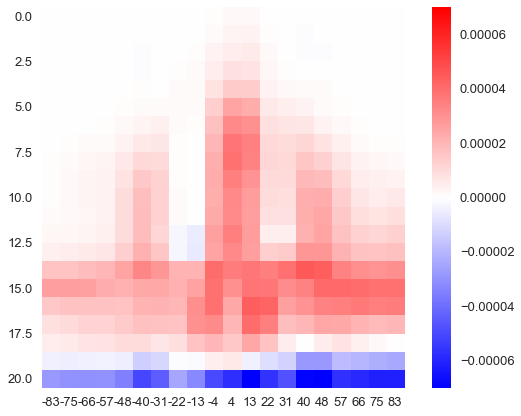

In [66]:
plt.imshow(b[0], cmap='bwr', vmin=-7e-5, vmax=7e-5)
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()

The ITCZ and the storm tracks are nicely visible. Let's also look at the variability

In [67]:
b = binned_statistic(lats, spdt, bins=20, statistic='std', range=(lats.min(), lats.max()))

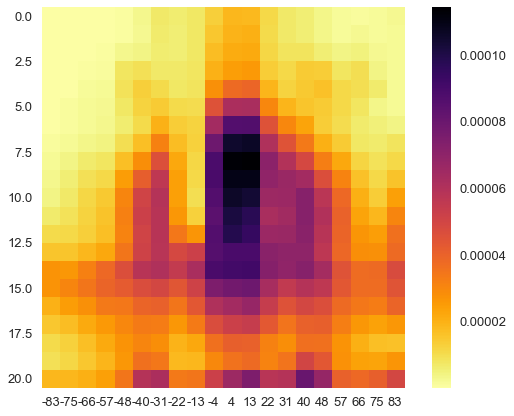

In [70]:
plt.imshow(b[0], cmap='inferno_r')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()

Correlates pretty well wit the means. By far the largest variability seems to be in the tropics.

Next, let's actually look at the features and targets for a few examples.

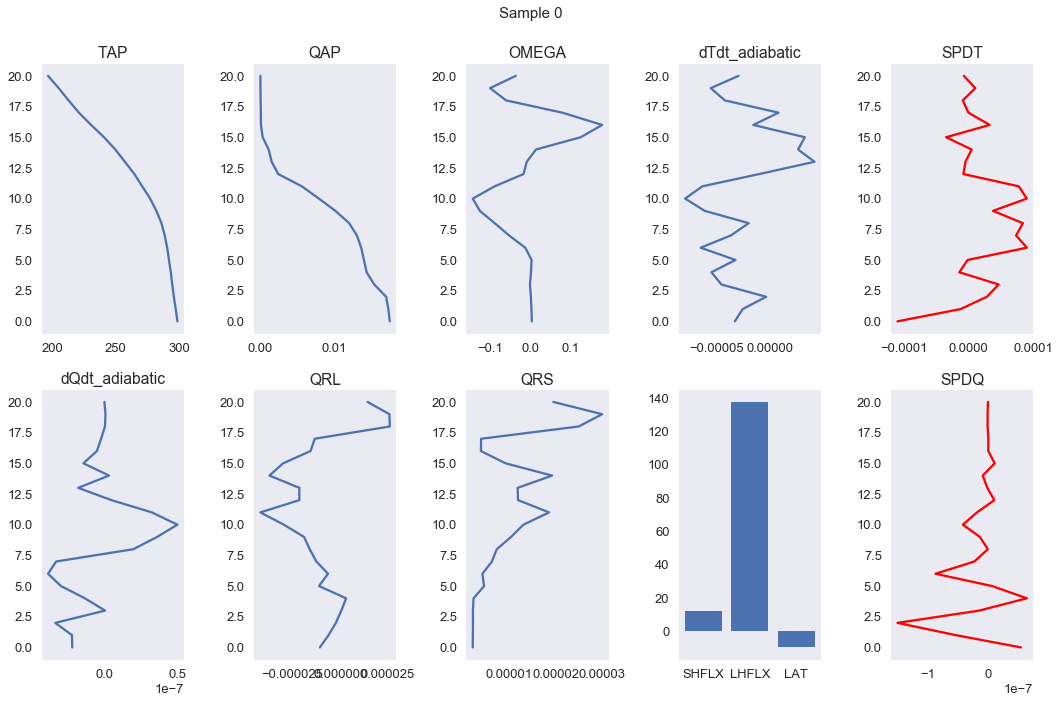

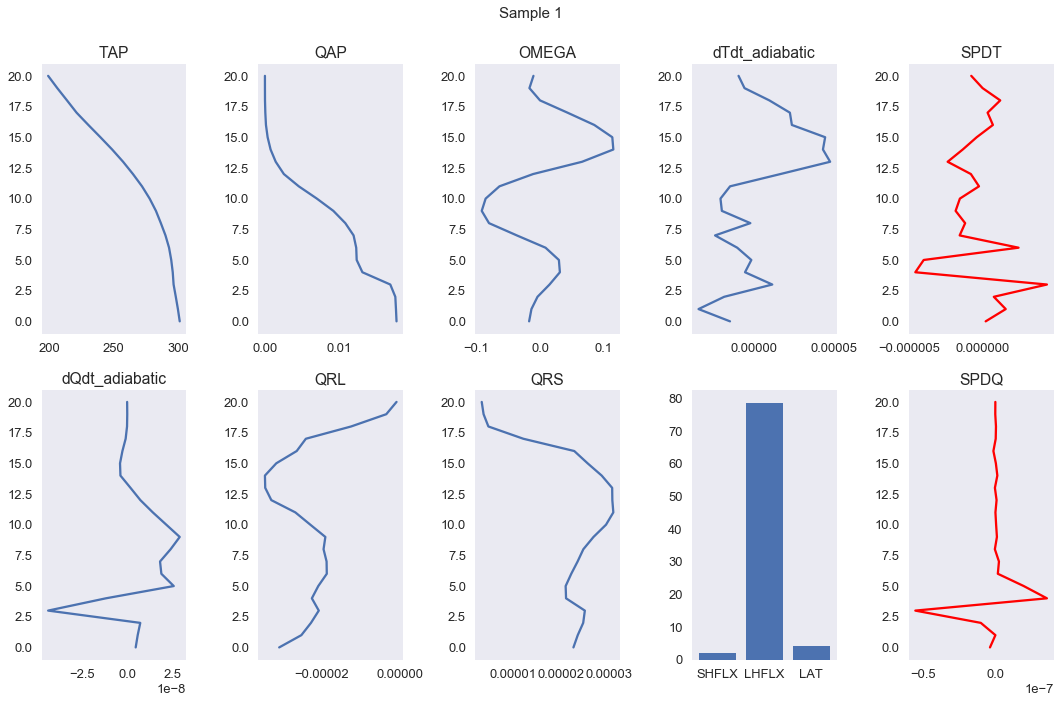

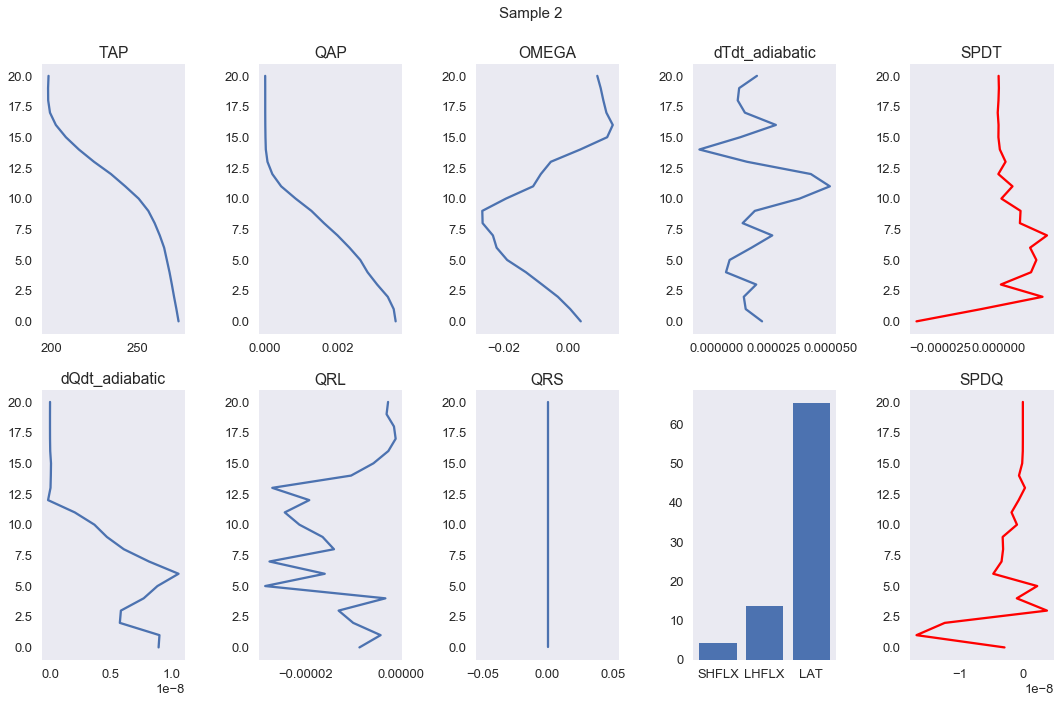

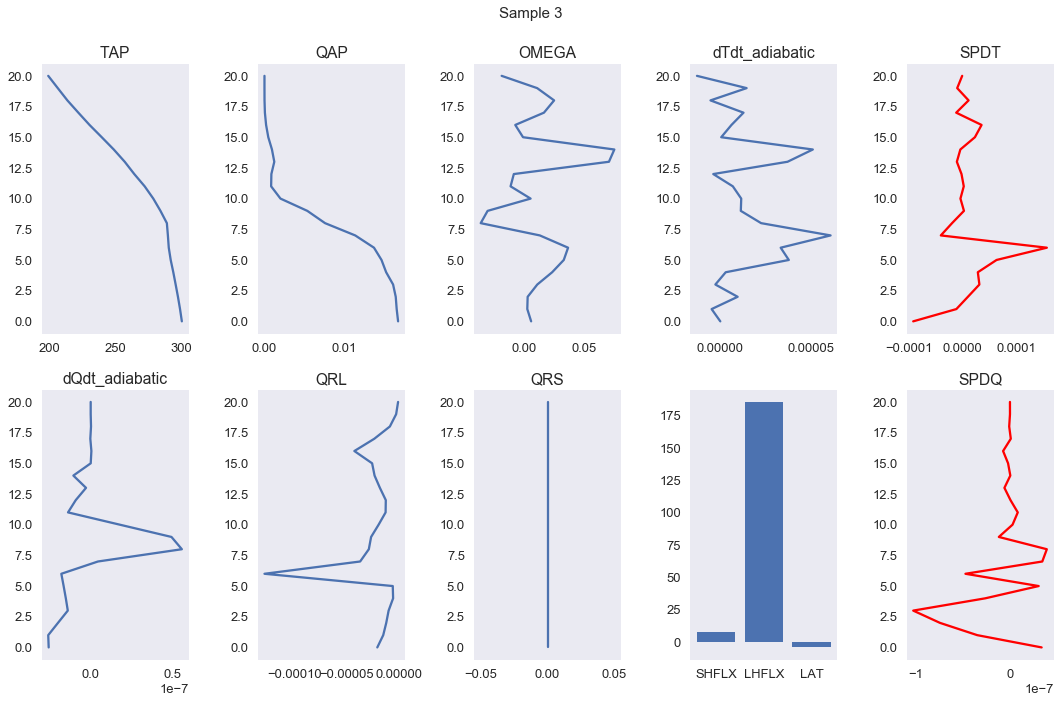

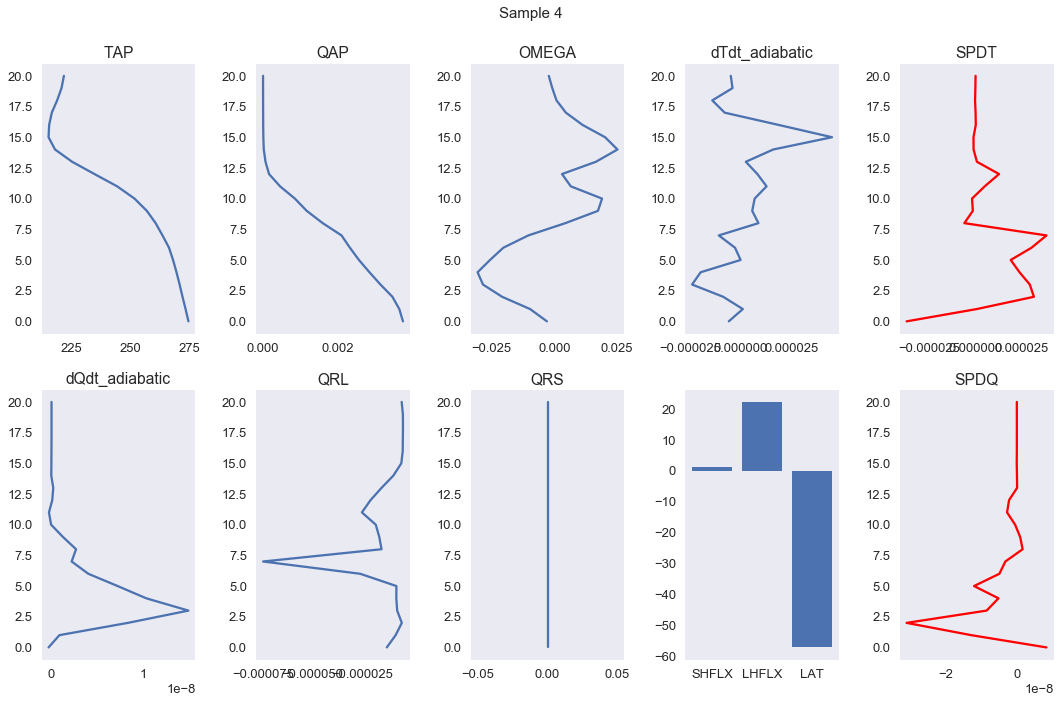

In [78]:
for i in range(5):
    vis_features_targets(train_out, i, feature_vars, target_vars)

Some thoughts for better visualization:
- Use scaled features and targets

## Some tests with Keras

### Fully connected neural network
I wrote a DataGenerator class which loads and scales the features and targets. This loads the entire dataset into RAM, so for the full dataset it might be quite memory intensive!

In [6]:
train_batches = DataGenerator(data_dir, 'SPCAM_outputs_train.nc', 4096, feature_vars.keys())
valid_batches = DataGenerator(data_dir, 'SPCAM_outputs_valid.nc', 4096, feature_vars.keys())

This uses about 12GB of CPU RAM. So make sure not to have several DataGenerators at the same time.

In [7]:
# Create model
model = fc_model(train_batches.features.shape[1], train_batches.targets.shape[1], 
                 [32, 32], 0.001, 'mae')

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                4832      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 42)                1386      
Total params: 7,274
Trainable params: 7,274
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit_generator(train_batches.generate(shuffle=True), train_batches.n_batches, epochs=10,
                    validation_data=valid_batches.generate(shuffle=False),
                    validation_steps=valid_batches.n_batches,
                    callbacks=[TensorBoard(log_dir='../logs/keras_fc_reference/')])

Epoch 1/10
902/902 [==============================] - 12s - loss: 0.0205 - rmse: 0.0374 - log_loss: -1.5766 - total_error: 723.7442 - unexplained_error: 462.4832 - rsquared: 0.3608 - total_error_avgAx0: 629.0795 - rsquared_avgAx0: 0.2645 - val_loss: 0.0205 - val_rmse: 0.0374 - val_log_loss: -1.5763 - val_total_error: 723.2040 - val_unexplained_error: 463.6933 - val_rsquared: 0.3586 - val_total_error_avgAx0: 628.7150 - val_rsquared_avgAx0: 0.2621
Epoch 2/10
902/902 [==============================] - 12s - loss: 0.0205 - rmse: 0.0374 - log_loss: -1.5767 - total_error: 723.7442 - unexplained_error: 462.2306 - rsquared: 0.3612 - total_error_avgAx0: 629.0795 - rsquared_avgAx0: 0.2649 - val_loss: 0.0206 - val_rmse: 0.0376 - val_log_loss: -1.5730 - val_total_error: 723.2040 - val_unexplained_error: 465.7436 - val_rsquared: 0.3558 - val_total_error_avgAx0: 628.7150 - val_rsquared_avgAx0: 0.2589
Epoch 3/10
902/902 [==============================] - 13s - loss: 0.0205 - rmse: 0.0374 - log_loss: 

### Convolutional neural network

In [33]:
train_batches = DataGenerator(data_dir, 'SPCAM_outputs_train.nc', 128, feature_vars.keys(),
                              convolution=True)
valid_batches = DataGenerator(data_dir, 'SPCAM_outputs_valid.nc', 128, feature_vars.keys(),
                              convolution=True)

In [34]:
train_batches.features[0].shape, train_batches.features[1].shape

((3696230, 21, 7), (3696230, 3))

In [35]:
model = conv_model(train_batches.features[0].shape[1:], train_batches.features[1].shape[1],
                   train_batches.targets.shape[1], [32, 32], [100], 1e-3, 'mae')

In [36]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 21, 7)         0                                            
____________________________________________________________________________________________________
conv1d_8 (Conv1D)                (None, 21, 32)        704         input_9[0][0]                    
____________________________________________________________________________________________________
conv1d_9 (Conv1D)                (None, 21, 32)        3104        conv1d_8[0][0]                   
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 672)           0           conv1d_9[0][0]                   
___________________________________________________________________________________________

In [37]:
model.fit_generator(train_batches.generate(shuffle=True), train_batches.n_batches, epochs=10,
                    validation_data=valid_batches.generate(shuffle=False),
                    validation_steps=valid_batches.n_batches,
                    callbacks=[TensorBoard(log_dir='../logs/keras_conv_reference/')])

Epoch 1/10
28876/28876 [==============================] - 244s - loss: 0.0177 - rmse: 0.0324 - log_loss: -1.6343 - total_error: 22.6303 - unexplained_error: 10.9960 - rsquared: 0.5114 - total_error_avgAx0: 19.5227 - rsquared_avgAx0: 0.4314 - val_loss: 0.0171 - val_rmse: 0.0312 - val_log_loss: -1.6495 - val_total_error: 22.5972 - val_unexplained_error: 10.2375 - val_rsquared: 0.5446 - val_total_error_avgAx0: 19.4996 - val_rsquared_avgAx0: 0.4703
Epoch 2/10
28876/28876 [==============================] - 247s - loss: 0.0170 - rmse: 0.0311 - log_loss: -1.6530 - total_error: 22.6303 - unexplained_error: 10.1967 - rsquared: 0.5472 - total_error_avgAx0: 19.5227 - rsquared_avgAx0: 0.4730 - val_loss: 0.0170 - val_rmse: 0.0310 - val_log_loss: -1.6531 - val_total_error: 22.5972 - val_unexplained_error: 10.0842 - val_rsquared: 0.5514 - val_total_error_avgAx0: 19.4996 - val_rsquared_avgAx0: 0.4781
Epoch 3/10
28876/28876 [==============================] - 244s - loss: 0.0170 - rmse: 0.0309 - log_los

### A better network?

In [ ]:
train_batches = DataGenerator(data_dir, 'SPCAM_outputs_train.nc', 1024, feature_vars.keys(),
                              convolution=True)
valid_batches = DataGenerator(data_dir, 'SPCAM_outputs_valid.nc', 1024, feature_vars.keys(),
                              convolution=True)

In [ ]:
model = conv_model(train_batches.features[0].shape[1:], train_batches.features[1].shape[1],
                   train_batches.targets.shape[1], [32, 32, 32], [500, 500], 1e-3, 'mae')

In [ ]:
model.summary()

In [ ]:
model.fit_generator(train_batches.generate(shuffle=True), train_batches.n_batches, epochs=1,
                    validation_data=valid_batches.generate(shuffle=False),
                    validation_steps=valid_batches.n_batches,
                    callbacks=[TensorBoard(log_dir='../logs/keras_conv_2/')])

## Visualize predictions

In [52]:
preds = model.predict_generator(valid_batches.generate(shuffle=False), valid_batches.n_batches)  

In [53]:
preds.shape

(924032, 42)

In [54]:
valid_batches.targets.shape

(924058, 42)

In [55]:
# split into spdt and spdq
preds = np.reshape(preds, (preds.shape[0], 21, 2))
true = np.reshape(valid_batches.targets, (valid_batches.targets.shape[0], 21, 2))

In [112]:
# E along z axis
error = preds[:, :, :] - true[:preds.shape[0], :, :] 
error = np.reshape(error, (error.shape[0], -1))
error_dt = preds[:, :, 0] - true[:preds.shape[0], :, 0] 
error_dq = preds[:, :, 1] - true[:preds.shape[0], :, 1] 

In [58]:
mae = np.mean(np.abs(preds[:, :, :] - true[:preds.shape[0], :, :]))
mae

0.016872659388635268

In [59]:
np.mean(np.abs(preds[:, :, 0] - true[:preds.shape[0], :, 0]))

0.016644356283999021

In [60]:
np.mean(np.abs(preds[:, :, 1] - true[:preds.shape[0], :, 1]))

0.017100962493271643

In [96]:
np.mean(np.abs(true[:preds.shape[0], :, :]))

0.025882592534425354

In [70]:
lats = valid_batches.features[1][:preds.shape[0], -1]

In [77]:
# RMSE
def rmse_stat(x):
    return np.sqrt(np.mean(x**2))

In [84]:
def plot_lat_z_statistic(a, lats, statistic, cmap='inferno', vmin=None, vmax=None):
    b = binned_statistic(lats, a.T, statistic=statistic, bins=20, 
                         range=(lats.min(), lats.max()))
    mean_lats = (b[1][1:] + b[1][:-1]) / 2.
    mean_lats = ['%.0f' % l for l in mean_lats]
    plt.imshow(b[0], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(range(len(mean_lats)), mean_lats)
    plt.colorbar()
    plt.show()

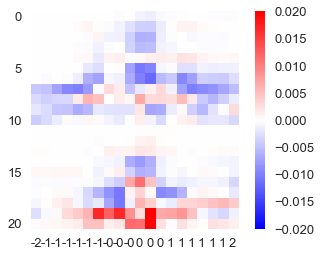

In [86]:
plot_lat_z_statistic(error_dt, lats, 'mean', 'bwr', -0.02, 0.02)

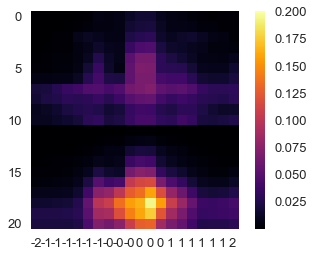

In [91]:
plot_lat_z_statistic(error_dt, lats, rmse_stat, vmax=0.2)

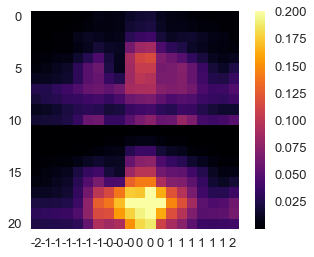

In [94]:
plot_lat_z_statistic(true[:preds.shape[0], :, 0], lats, np.std, vmax=0.2)

In [95]:
train_preds = model.predict_generator(train_batches.generate(shuffle=False), 
                                      train_batches.n_batches)

In [98]:
train_preds = np.reshape(train_preds, (train_preds.shape[0], 21, 2))
train_true = np.reshape(train_batches.targets, (train_batches.targets.shape[0], 21, 2))
train_preds.shape, train_true.shape

((3696128, 21, 2), (3696230, 21, 2))

In [99]:
# E along z axis
train_error_dt = train_preds[:, :, 0] - train_true[:train_preds.shape[0], :, 0] 
train_error_dq = train_preds[:, :, 1] - train_true[:train_preds.shape[0], :, 1] 

In [100]:
np.mean(np.abs(train_preds[:, :, :] - train_true[:train_preds.shape[0], :, :]))

0.016851513251780553

In [101]:
np.mean(np.abs(train_true[:train_preds.shape[0], :, :]))

0.025881500968938109

In [102]:
var = np.var(true)
var

0.004203581800124913

In [105]:
se = np.mean((preds[:, :, :] - true[:preds.shape[0], :, :]) ** 2)
se

0.0018571880335468524

In [106]:
1 - (se / var)

0.55818915347581322

In [107]:
se / var

0.44181084652418673

In [108]:
0.016/0.025

0.64

In [113]:
binned_se = binned_statistic(lats, error.T ** 2, statistic=np.mean, bins=20,
                              range=(lats.min(), lats.max()))

In [118]:
np.reshape(true, (true.shape[0], -1)).T[:, :preds.shape[0]]

(42, 924058)

In [119]:
error.T.shape

(42, 924032)

In [120]:
binned_var = binned_statistic(lats, np.reshape(true, (true.shape[0], -1)).T[:, :preds.shape[0]],
                              statistic=np.var, bins=20,
                              range=(lats.min(), lats.max()))

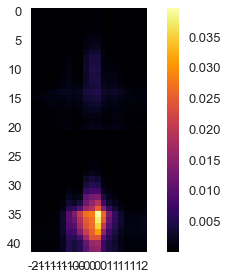

In [122]:
plt.imshow(binned_se[0], cmap='inferno')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

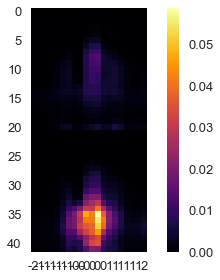

In [123]:
plt.imshow(binned_var[0], cmap='inferno')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

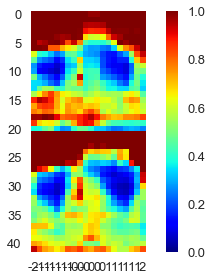

In [129]:
plt.imshow(binned_se[0] / binned_var[0], cmap='jet', vmin=0, vmax=1)
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

1271.2118255735274